In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# read data
df = pd.read_csv('..\..\..\数据集\因果识别数据集\groupon.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


In [5]:
#check the means of control and treatment
df.groupby('treatment').mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
treatment,,,,,,,,,,
0,1.00000,3.809717,37.870445,52.973684,95.941296,0.105263,0.852227,77.941296,333.002024,9720.987854
1,26.50463,3.379630,29.421296,53.263889,131.842593,0.143519,0.777778,113.203704,509.351852,12750.694444


In [6]:
#separate control and treatment for t-test
df_control = df[df.treatment == 0]
df_treatment = df[df.treatment == 1]

In [7]:
#t-test the revenue of two group 
from scipy.stats import ttest_ind

print(df_control.revenue.mean(), df_treatment.revenue.mean())
#compare samples
_, p = ttest_ind(df_control.revenue, df_treatment.revenue)
print(f'p={p:.3f}')

#set 5%
alpha = 0.05
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')   

9720.987854251012 12750.694444444445
p=0.040
different distributions/different group mean (reject H0)


In [8]:
#t-test for facebook likes (dependent variable)
from scipy.stats import ttest_ind

print(df_control.fb_likes.mean(), df_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_control.fb_likes, df_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

77.9412955465587 113.20370370370371
p=0.004
different distributions/different group mean (reject H0)


In [9]:
# choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
y = df['treatment']

X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [17]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

# get the coefficients 
lr.coef_.reshape(-1)

array([-0.32837145, -0.0085971 , -0.00794035,  0.00352025,  0.30799437,
       -0.36649825])

In [15]:
# get the feature names
X.columns.to_numpy()

# combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.reshape(-1),
})
coeffs

,column,coeff
0,prom_length,-0.328371
1,price,-0.008597
2,discount_pct,-0.007940
3,coupon_duration,0.003520
4,featured,0.307994
5,limited_supply,-0.366498


In [18]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 0
the corresponding probabilities are: [0.74080755 0.25919245]


In [21]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
# I just use the propensity score to match in this tutorial
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps_logit
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259192,-1.050170
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230198,-1.207194
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288405,-0.903144
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511781,0.047131
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325212,-0.729919


<AxesSubplot:xlabel='ps', ylabel='Count'>

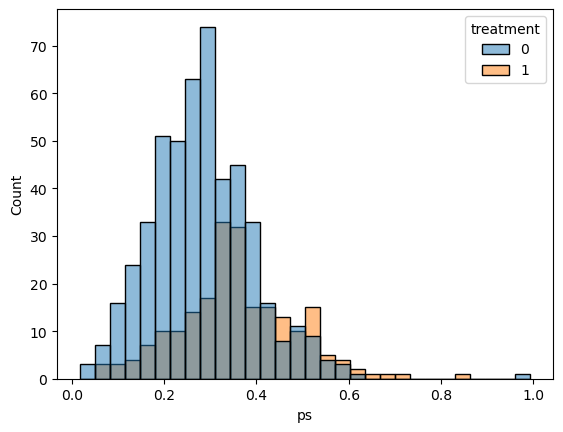

In [22]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')

<AxesSubplot:xlabel='ps1', ylabel='Count'>

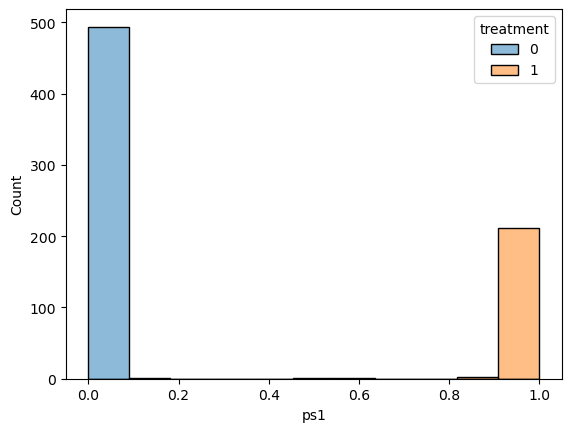

In [23]:
# delete features
# adding 'min_req' here makes matching not working - because treatment is derived from min_req
# there is no overlap and thus matching will not work
X1 = df[['min_req', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X1, y)

pred_prob1 = lr1.predict_proba(X1)  # probabilities for classes
df['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df, x='ps1', hue='treatment')

<AxesSubplot:xlabel='start_date', ylabel='revenue'>

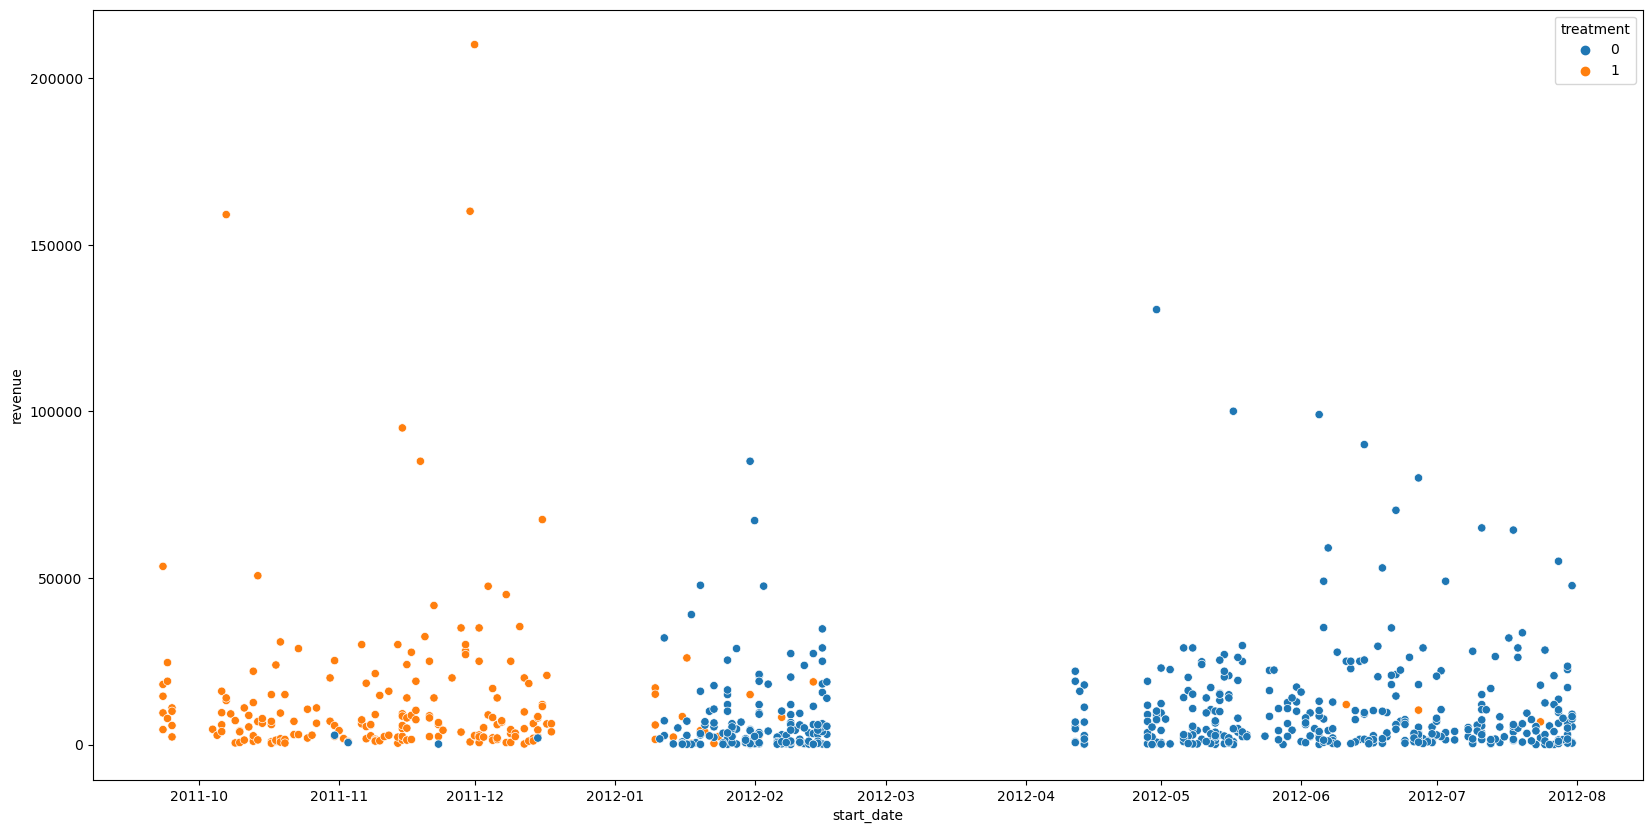

In [24]:
# stating date can also determine treatment value for most cases
# so we do not include it in the propensity score calculation
df.start_date = pd.to_datetime(df.start_date)
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=df, x='start_date', y='revenue', hue='treatment')

<AxesSubplot:xlabel='ps2', ylabel='Count'>

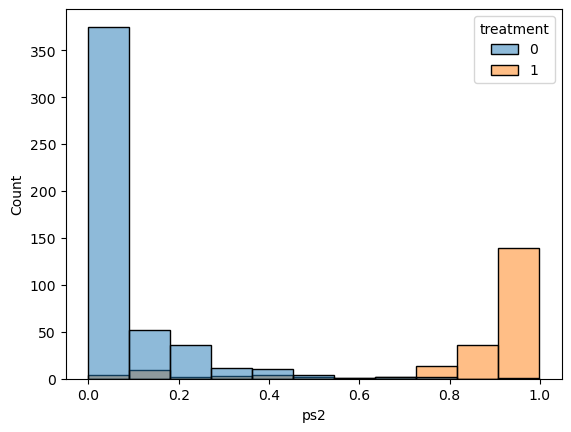

In [25]:
# adding 'starting_date' here via a `recency` feature
# there is only little overlap resulting in not enough matched observations

last_date = df.start_date.max()
df['recency'] = (last_date - df.start_date).dt.days

X2 = df[['recency', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2, y)

pred_prob2 = lr2.predict_proba(X2)  # probabilities for classes
df['ps2'] = pred_prob2[:, 1]

sns.histplot(data=df, x='ps2', hue='treatment')

In [26]:
# use 25% of standard deviation of the propensity score as the caliper/radius
# get the k closest neighbors for each observations
# relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0304


NearestNeighbors(n_neighbors=10, radius=0.03037911774845534)

In [27]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(710, 10)
[0.         0.00010803 0.00040672 0.00078194 0.0011583  0.00135213
 0.00135213 0.00164933 0.00166944 0.0020385 ]
[  0 348 388 415 624 494 150 463 372 345]


In [28]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df.iterrows():  # iterate over the dataframe
    if row.treatment == 0:  # the current row is in the control group
        df.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df.loc[idx].treatment == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break
                    
print('total observations in treatment:', len(df[df.treatment==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 216
total matched observations in control: 185


In [29]:
# control have no match
treatment_matched = df.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched.astype(int)  # change to int
control_matched = df.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

df_matched.treatment.value_counts()

1    185
0    185
Name: treatment, dtype: int64

In [30]:
# matched control and treatment
df_matched_control = df_matched[df_matched.treatment==0]
df_matched_treatment = df_matched[df_matched.treatment==1]

# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.revenue.mean(), df_matched_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_matched_control.revenue, df_matched_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9146.783783783783 13275.405405405405
p=0.051
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [31]:
from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s


effect_sizes = []
cols = ['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']

for cl in cols:
    _, p_before = ttest_ind(df_control[cl], df_treatment[cl])
    _, p_after = ttest_ind(df_matched_control[cl], df_matched_treatment[cl])
    cohen_d_before = cohen_d(df_treatment[cl], df_control[cl])
    cohen_d_after = cohen_d(df_matched_treatment[cl], df_matched_control[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])

df_effect_sizes = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes

,feature,matching,effect_size,p-value
0,prom_length,before,-0.328313,0.000063
1,prom_length,after,-0.055414,0.594388
2,price,before,-0.233573,0.004315
3,price,after,-0.004145,0.968225
4,discount_pct,before,0.035411,0.664344
5,discount_pct,after,0.118635,0.254612
6,coupon_duration,before,0.282300,0.000571
7,coupon_duration,after,-0.032618,0.753920
8,featured,before,0.119074,0.144802
9,featured,after,-0.030542,0.769122


<AxesSubplot:xlabel='effect_size', ylabel='feature'>

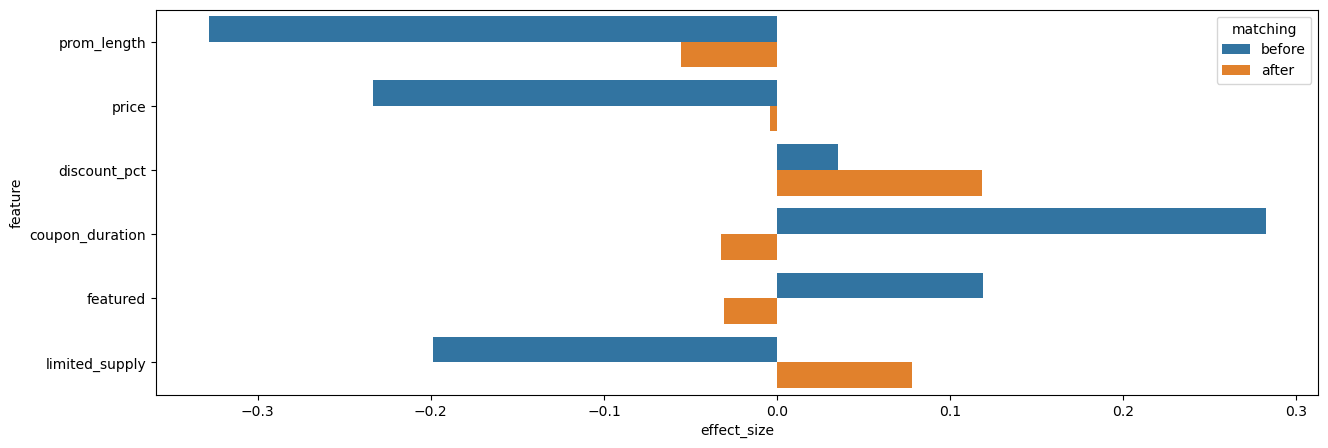

In [32]:
# discount_pct and featured are not significant, all other features are more balanced after matching
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes, x='effect_size', y='feature', hue='matching', orient='h')